In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastai.callbacks.tracker import *

torch.backends.cudnn.benchmark = True

import time

In [3]:
import fastai;fastai.__version__ #safety check

'1.0.57'

In [4]:
import torch; torch.__version__ #safety check

'1.2.0'

In [5]:
from deepmemory import DeepMemory

In [6]:
from mxresnet import *

Mish activation loaded...


In [7]:
path = untar_data(URLs.IMAGENETTE_160); path  #optional - IMAGENETTE

PosixPath('/home/ubuntu/.fastai/data/imagenette-160')

In [8]:
def flattenAnneal(learn:Learner, lr:float, n_epochs:int, start_pct:float):
  n = len(learn.data.train_dl)
  anneal_start = int(n*n_epochs*start_pct)
  anneal_end = int(n*n_epochs) - anneal_start
  phases = [TrainingPhase(anneal_start).schedule_hp('lr', lr),
           TrainingPhase(anneal_end).schedule_hp('lr', lr, anneal=annealing_cos)]
  sched = GeneralScheduler(learn, phases)
  learn.callbacks.append(sched)
  learn.fit(n_epochs)


In [9]:
tfms = ([

        flip_lr(p=0.5)#,
        #brightness(change=(0.4,0.6)),
        #contrast(scale=(0.7,1.3)),
        #cutout(n_holes=(2,40),length=(5,30),p=.25)

    ], [])

In [10]:
bs=64
size=128

In [11]:
data = (ImageList.from_folder(path)
        .split_by_folder(valid='val')
        .label_from_folder()
        .transform(tfms=tfms,size=size) 
        .databunch(bs=bs, num_workers=8)  #windows 10 users - num_workers may need to be set to 1 or 0 (if you get pickle fork error)
        .presize(size, scale=(0.5, 1))
        .normalize(imagenet_stats))

In [12]:
memory_size = (len(data.x)//bs);memory_size  #should be equal to or close to # of batches per epoch in order to build an average step size for the dataset

201

In [13]:
optar = partial(DeepMemory,betas=(.95,.999),len_memory = memory_size)

In [14]:
model = mxresnet50(sa=1)

In [15]:
learn = Learner(data, model, metrics=[accuracy], wd=1e-3,
                opt_func=optar,
                 bn_wd=False, true_wd=True,
                loss_func = LabelSmoothingCrossEntropy())

In [16]:
learn.callback_fns += [
        partial(ShowGraph),
        #partial(SaveModelCallback, name='model-novotest-1')
    ]

DeepMemory: length of memory is 201 - this should be close or equal to batches per epoch


epoch,train_loss,valid_loss,accuracy,time
0,2.571196,2.547925,0.432000,00:41
1,2.228164,2.119214,0.604000,00:38
2,2.080257,1.947510,0.666000,00:37
3,1.979283,2.059222,0.636000,00:37
4,1.887242,1.752053,0.742000,00:37
5,1.838371,1.779305,0.732000,00:37
6,1.801879,1.786606,0.728000,00:37
7,1.728110,1.704001,0.752000,00:37
8,1.699986,1.714347,0.758000,00:37
9,1.681988,1.630025,0.784000,00:37


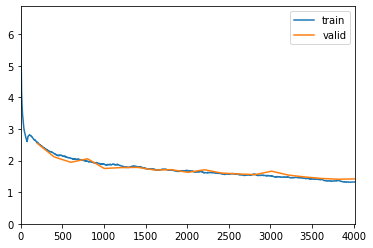

In [17]:
flattenAnneal(learn,4e-3, 20, .72) #imagenette

epoch,train_loss,valid_loss,accuracy,time
0,2.783504,2.846070,0.292000,00:38
1,2.514973,2.656390,0.374000,00:36
2,2.331984,2.586760,0.400000,00:36
3,2.211190,2.379511,0.478000,00:36
4,2.086747,2.122940,0.586000,00:35
5,1.977175,2.192198,0.580000,00:36
6,1.890428,1.988842,0.636000,00:36
7,1.804230,2.107334,0.610000,00:36
8,1.743078,1.851416,0.698000,00:36
9,1.703422,1.778018,0.720000,00:36


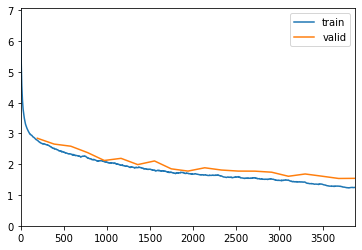

In [23]:
flattenAnneal(learn,4e-3, 20, .72)